In [1]:
from datetime import timedelta

import matplotlib.pyplot as plt
import pandas as pd
from scipy import integrate

plt.rcParams["savefig.dpi"] = 240

In [2]:
sm15k_supply = (
    pd.read_parquet("data/sm15k/supply.parquet", columns=["_time", "voltage", "current"])
    .rename(columns={"_time": "time"})
    .set_index("time")
)
un38_3 = pd.read_csv("../UN38.3/cycles.csv", index_col="cycle")

sm15k_supply.describe()

,voltage,current
count,5.044429e+06,5.044429e+06
mean,2.272403e+01,4.790729e-01
std,2.267224e+00,5.745173e+01
min,1.500150e+01,-7.292090e+01
25%,2.108240e+01,-7.200460e+01
50%,2.308090e+01,3.270000e-02
75%,2.516820e+01,7.197190e+01
max,2.521600e+01,7.270820e+01


In [3]:
from typing import Callable


def find_rising_edges(condition: pd.Series, drop: bool = True) -> pd.Series:
    mask = condition.astype(int).diff().fillna(0).astype(int) == 1
    if drop:
        return condition.loc[mask]
    return mask


def refine_condition(
    data: pd.Series,
    fn: Callable[[pd.DataFrame], bool],
    df: pd.DataFrame = sm15k_supply,
    dt: timedelta = timedelta(seconds=20),
) -> pd.Series:
    data = data.copy()
    data.index = pd.Index([fn(df.loc[ts - dt : ts + dt]).idxmax() for ts in data.index], name=data.index.name)
    return data

In [4]:
_current = sm15k_supply.loc["2024-10-25 17:30+00:00":, "current"].resample("10s").mean().interpolate(method="linear")

discharge_start = (
    find_rising_edges(_current < -24).pipe(refine_condition, fn=lambda df: df.current < -1).rename("discharge_start")
)
discharge_end = (
    find_rising_edges(_current > -24).pipe(refine_condition, fn=lambda df: df.current > -1).rename("discharge_end")
)
charge_start = (
    find_rising_edges(_current > 24).pipe(refine_condition, fn=lambda df: df.current > 1).rename("charge_start")
)
charge_end = (
    find_rising_edges(_current < 600e-3).pipe(refine_condition, fn=lambda df: df.current < -600e-3).rename("charge_end")
)

_df = pd.concat([discharge_start, discharge_end, charge_start, charge_end], axis=1).fillna(0).astype(bool)

assert all(_df[_df.sum(axis=1) == 1])
display(_df.sum(axis=0))

discharge_start    52
discharge_end      52
charge_start       52
charge_end         52
dtype: int64

In [5]:
cycles = pd.concat(
    [
        discharge_start.reset_index().time.dt.floor("100ms").rename("dsg_start"),
        discharge_end.reset_index().time.dt.ceil("100ms").rename("dsg_end"),
        charge_start.reset_index().time.dt.floor("100ms").rename("chg_start"),
        charge_end.reset_index().time.dt.ceil("100ms").rename("chg_end"),
    ],
    axis=1,
)
cycles.index = pd.RangeIndex(1, len(cycles) + 1, name="cycle")

df = sm15k_supply.resample("100ms").mean().interpolate()
df["power"] = df["voltage"] * df["current"]
df["cycle"] = -1
df["phase"] = ""

for cycle, cs, ce, ds, de in cycles[["chg_start", "chg_end", "dsg_start", "dsg_end"]].dropna().itertuples():
    df.loc[cs:ce, "cycle"] = cycle
    df.loc[ds:de, "cycle"] = cycle
    df.loc[cs:ce, "phase"] = "charge"
    df.loc[ds:de, "phase"] = "discharge"

charge_Ah = (
    df.loc[df["cycle"] != -1]
    .groupby(["cycle", "phase"])["current"]
    .aggregate(integrate.trapezoid, dx=0.1)
    .divide(3600)
    .unstack()
)
energy_Wh = (
    df.loc[df["cycle"] != -1]
    .groupby(["cycle", "phase"])["power"]
    .aggregate(integrate.trapezoid, dx=0.1)
    .divide(3600)
    .unstack()
)

cycles["dsg_start"] = cycles["dsg_start"].dt.floor("1s")
cycles["dsg_end"] = cycles["dsg_end"].dt.ceil("1s")
cycles["chg_start"] = cycles["chg_start"].dt.floor("1s")
cycles["chg_end"] = cycles["chg_end"].dt.ceil("1s")

cycles["dsg_duration"] = cycles["dsg_end"] - cycles["dsg_start"]
cycles["chg_duration"] = cycles["chg_end"] - cycles["chg_start"]
cycles["dsg_charge_Ah"] = charge_Ah["discharge"]
cycles["chg_charge_Ah"] = charge_Ah["charge"]
cycles["dsg_energy_Wh"] = energy_Wh["discharge"]
cycles["chg_energy_Wh"] = energy_Wh["charge"]
cycles["energy_loss_Wh"] = cycles["chg_energy_Wh"] + cycles["dsg_energy_Wh"]

cycles.to_csv("cycles.csv")


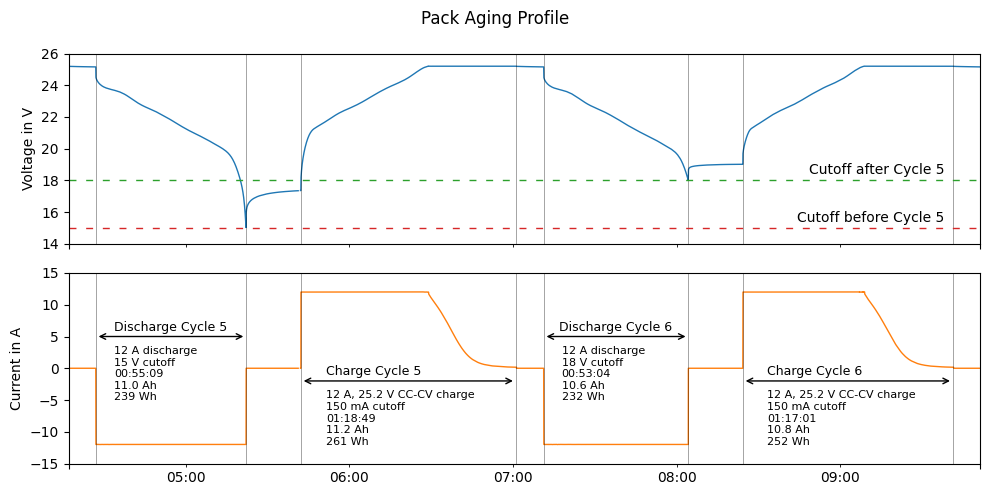

In [6]:
from matplotlib.patches import FancyArrowPatch

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

start = cycles.loc[5, "dsg_start"] - timedelta(minutes=10)
end = cycles.loc[6, "chg_end"] + timedelta(minutes=10)

sm15k_supply.loc[start:end, "voltage"].resample("1s").mean().plot(ax=ax1, lw=1, c="C0", ylim=(14, 26))
sm15k_supply.loc[start:end, "current"].resample("1s").mean().div(6).plot(ax=ax2, lw=1, c="C1", ylim=(-15, 15))

# Mark discharge and charge phases
for cycle, row in cycles.loc[5:6].iterrows():
    for ax in [ax1, ax2]:
        ax.axvline(row["dsg_start"], c="k", alpha=0.5, lw=0.5)
        ax.axvline(row["dsg_end"], c="k", alpha=0.5, lw=0.5)
        ax.axvline(row["chg_start"], c="k", alpha=0.5, lw=0.5)
        ax.axvline(row["chg_end"], c="k", alpha=0.5, lw=0.5)

    arrow = FancyArrowPatch(
        (row["dsg_start"], 5),
        (row["dsg_end"], 5),
        arrowstyle="<->",
        mutation_scale=10,
    )
    ax2.add_patch(arrow)
    ax2.annotate(
        f"Discharge Cycle {cycle}",
        xy=(0.5, 1),
        xycoords=arrow,
        ha="center",
        va="bottom",
        fontsize=9,
    )
    cutoff = 15 if cycle <= 5 else 18
    dur = row["dsg_duration"].components
    ax2.annotate(
        f"12 A discharge\n"
        f"{cutoff} V cutoff\n"
        f"{dur.hours:02d}:{dur.minutes:02d}:{dur.seconds:02d}\n"
        f"{abs(row['dsg_charge_Ah'])/6:.1f} Ah\n"
        f"{abs(row['dsg_energy_Wh'])/6:.0f} Wh",
        xy=(0.1, -1.2),
        xycoords=arrow,
        ha="left",
        va="top",
        fontsize=8,
    )

    arrow = FancyArrowPatch(
        (row["chg_start"], -2),
        (row["chg_end"], -2),
        arrowstyle="<->",
        mutation_scale=10,
    )
    ax2.add_patch(arrow)
    ax2.annotate(
        f"Charge Cycle {cycle}",
        xy=(0.1, 1),
        xycoords=arrow,
        ha="left",
        va="bottom",
        fontsize=9,
    )
    dur = row["chg_duration"].components
    ax2.annotate(
        f"12 A, 25.2 V CC-CV charge\n"
        f"150 mA cutoff\n"
        f"{dur.hours:02d}:{dur.minutes:02d}:{dur.seconds:02d}\n"
        f"{abs(row['chg_charge_Ah'])/6:.1f} Ah\n"
        f"{abs(row['chg_energy_Wh'])/6:.0f} Wh",
        xy=(0.1, -1.2),
        xycoords=arrow,
        ha="left",
        va="top",
        fontsize=8,
    )

ax1.axhline(15, c="C3", ls=(0, (5, 7)), lw=1)
ax1.axhline(18, c="C2", ls=(0, (5, 7)), lw=1)

ax1.text(cycles.loc[6, "chg_end"] - timedelta(minutes=3), 15.2, "Cutoff before Cycle 5", ha="right", va="bottom")
ax1.text(cycles.loc[6, "chg_end"] - timedelta(minutes=3), 18.2, "Cutoff after Cycle 5", ha="right", va="bottom")

ax1.set_ylabel("Voltage in V")
ax2.set_ylabel("Current in A")
ax2.set_xlabel(None)

fig.suptitle("Pack Aging Profile")
fig.tight_layout()
fig.savefig("img/aging-profile.png", dpi=240)

In [7]:
display(cycles)

,dsg_start,dsg_end,chg_start,chg_end,dsg_duration,chg_duration,dsg_charge_Ah,chg_charge_Ah,dsg_energy_Wh,chg_energy_Wh,energy_loss_Wh
cycle,,,,,,,,,,,
1,2024-10-25 17:30:21+00:00,2024-10-25 18:25:23+00:00,2024-10-25 18:45:22+00:00,2024-10-25 20:04:01+00:00,0 days 00:55:02,0 days 01:18:39,-66.004166,66.992622,-1421.367193,1563.583376,142.216183
2,2024-10-25 20:14:18+00:00,2024-10-25 21:09:30+00:00,2024-10-25 21:29:29+00:00,2024-10-25 22:48:01+00:00,0 days 00:55:12,0 days 01:18:32,-66.198286,67.090912,-1431.432738,1565.323605,133.890867
3,2024-10-25 22:58:25+00:00,2024-10-25 23:53:37+00:00,2024-10-26 00:13:36+00:00,2024-10-26 01:32:21+00:00,0 days 00:55:12,0 days 01:18:45,-66.213236,67.096752,-1432.343948,1565.473404,133.129456
4,2024-10-26 01:42:40+00:00,2024-10-26 02:37:51+00:00,2024-10-26 02:57:50+00:00,2024-10-26 04:16:41+00:00,0 days 00:55:11,0 days 01:18:51,-66.187203,67.074830,-1432.043496,1565.039129,132.995633
5,2024-10-26 04:26:58+00:00,2024-10-26 05:22:07+00:00,2024-10-26 05:42:12+00:00,2024-10-26 07:01:01+00:00,0 days 00:55:09,0 days 01:18:49,-66.150297,67.032985,-1431.433804,1564.169163,132.735359
6,2024-10-26 07:11:17+00:00,2024-10-26 08:04:21+00:00,2024-10-26 08:24:20+00:00,2024-10-26 09:41:21+00:00,0 days 00:53:04,0 days 01:17:01,-63.664255,64.528395,-1389.335715,1514.070493,124.734778
7,2024-10-26 09:51:39+00:00,2024-10-26 10:44:39+00:00,2024-10-26 11:04:38+00:00,2024-10-26 12:21:51+00:00,0 days 00:53:00,0 days 01:17:13,-63.572034,64.437792,-1387.244458,1512.133686,124.889228
8,2024-10-26 12:32:06+00:00,2024-10-26 13:25:03+00:00,2024-10-26 13:45:02+00:00,2024-10-26 15:02:11+00:00,0 days 00:52:57,0 days 01:17:09,-63.512487,64.374337,-1385.954254,1510.736241,124.781987
9,2024-10-26 15:12:32+00:00,2024-10-26 16:05:26+00:00,2024-10-26 16:25:25+00:00,2024-10-26 17:42:31+00:00,0 days 00:52:54,0 days 01:17:06,-63.466270,64.327991,-1384.991528,1509.722180,124.730652


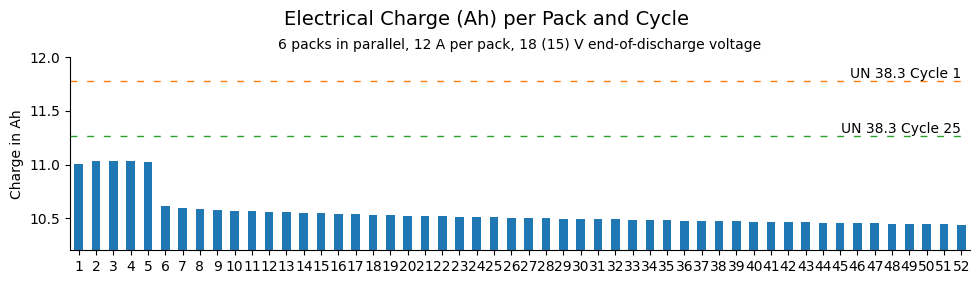

In [8]:
ax = cycles["dsg_charge_Ah"].mul(-1).div(6).plot.bar(figsize=(10, 3), ylim=(10.2, 12), ylabel="Charge in Ah")
plt.suptitle("Electrical Charge (Ah) per Pack and Cycle", y=0.93, fontsize=14)
ax.set_title(
    "6 packs in parallel, 12 A per pack, 18 (15) V end-of-discharge voltage",
    fontsize=10,
)

q01 = -un38_3.loc[1, "dsg_charge_Ah"] / 4
q25 = -un38_3.loc[25, "dsg_charge_Ah"] / 4
ax.axhline(q01, c="C1", ls=(0, (5, 7)), lw=1)
ax.axhline(q25, c="C2", ls=(0, (5, 7)), lw=1)
ax.text(len(cycles) - 1, q01, "UN 38.3 Cycle 1", ha="right", va="bottom")
ax.text(len(cycles) - 1, q25, "UN 38.3 Cycle 25", ha="right", va="bottom")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlabel(None)
ax.tick_params(axis="x", rotation=0)

plt.tight_layout()
plt.savefig("img/charge-per-cycle.png")


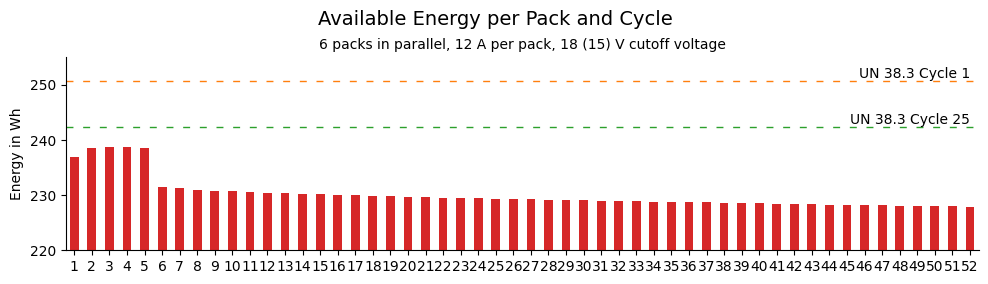

In [9]:
ax = cycles["dsg_energy_Wh"].div(-6).plot.bar(figsize=(10, 3), ylim=(220, 255), ylabel="Energy in Wh", color="C3")
plt.suptitle("Available Energy per Pack and Cycle", y=0.93, fontsize=14)
ax.set_title(
    "6 packs in parallel, 12 A per pack, 18 (15) V cutoff voltage",
    fontsize=10,
)

e01 = -un38_3.loc[1, "dsg_energy_Wh"] / 4
e25 = -un38_3.loc[25, "dsg_energy_Wh"] / 4
ax.axhline(e01, c="C1", ls=(0, (5, 7)), lw=1)
ax.axhline(e25, c="C2", ls=(0, (5, 7)), lw=1)
ax.text(len(cycles) - 1, e01, "UN 38.3 Cycle 1", ha="right", va="bottom")
ax.text(len(cycles) - 1, e25, "UN 38.3 Cycle 25", ha="right", va="bottom")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlabel(None)
ax.tick_params(axis="x", rotation=0)

plt.tight_layout()
plt.savefig("img/energy-per-cycle.png")


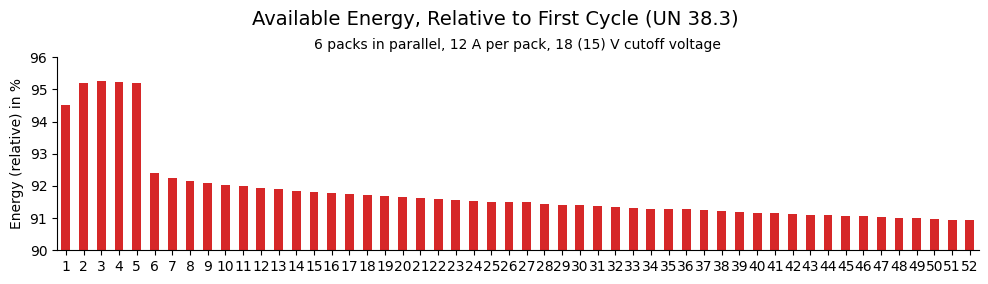

In [10]:
ax = (
    cycles["dsg_energy_Wh"]
    .div(6)
    .div(un38_3.loc[1, "dsg_energy_Wh"] / 4)
    .mul(100)
    .plot.bar(figsize=(10, 3), ylim=(90, 96), ylabel="Energy (relative) in %", color="C3")
)
plt.suptitle("Available Energy, Relative to First Cycle (UN 38.3)", y=0.93, fontsize=14)
ax.set_title(
    "6 packs in parallel, 12 A per pack, 18 (15) V cutoff voltage",
    fontsize=10,
)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlabel(None)
ax.tick_params(axis="x", rotation=0)

plt.tight_layout()
plt.savefig("img/relative-energy-per-cycle.png")
